In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
plt.style.use('seaborn-white')

<ipython-input-1-6d0fa4db7acd>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
import morl_custom
from env_LQG import LQG

# True PF

In [3]:
%%time
from optimal_lqg_solver import MO_LQG_return

ws = np.arange(0.01, 1, 0.01)
ws = np.hstack([ws.reshape(-1, 1), 1 - ws.reshape(-1, 1)])

opt_Rs = np.asarray([MO_LQG_return(xi=0.1, gamma=0.9, w=w, x_init=[10.0]*2, 
                                   n_repeat=1, T_horizon=30, noise_std=0)
         for w in ws])

CPU times: user 3.52 s, sys: 2.67 s, total: 6.19 s
Wall time: 3.06 s


# Train policy with LC-MOPG

In [4]:
def main(n_obj: int, c_dim: int, period_to_record_R: int):
    np.random.seed(2)        
    policy = morl_custom.make_policy_net(state_dim=n_obj, 
                                         hidden_dim=24, 
                                         act_space=('continuous', n_obj), 
                                         c_dim=c_dim, 
                                         seed=2,
                                         embed_dims=None, 
                                         std=0.2).to(morl_custom.DEVICE)

    out = morl_custom.learn(policy=policy, 
                            gradient_steps=500, 
                            n_grad_repeat=1, 
                            group_size_train=200, 
                            group_size_test=200, 
                            env=LQG(n_obj=n_obj, noise_std=0, a_max=11, normalizer=lambda x: x / 5.0 - 1.0), 
                            n_obj=n_obj, 
                            test_repeat=1, 
                            n_jobs=15, 
                            ep_len_train=30, 
                            ep_len_test=30, 
                            nn_k=3, 
                            beta=10.0, 
                            J_AU=np.asarray([-310.0] * n_obj), 
                            J_U=np.asarray([-150.0] * n_obj), 
                            gamma_train=0.9, 
                            gamma_test=0.9, 
                            mode='median', 
                            score_clipped_above_zero=True,
                            use_QV=False, 
                            QV_params=None,
                            period_to_record_R=period_to_record_R
                    )
    with open('out.pkl', 'wb') as f:
        pickle.dump(out, f)

In [5]:
%%time
main(n_obj=2, c_dim=2, period_to_record_R=25)

0 [0.03989] 1 [0.2778] 2 [0.0] 3 [0.0] 4 [0.01739] 5 [0.2513] 6 [0.1439] 7 [0.0] 8 [0.0] 9 [0.2586] 10 [0.0] 11 [0.0] 12 [0.2938] 13 [0.0] 14 [0.4066] 15 [0.4336] 16 [0.0] 17 [0.2049] 18 [0.5071] 19 [0.2777] 20 [0.3054] 21 [0.04482] 22 [0.3849] 23 [0.0] 24 [0.338] 25 [0.3624] 26 [0.2404] 27 [0.05421] 28 [0.3811] 29 [0.5047] 30 [0.2343] 31 [0.3673] 32 [0.4047] 33 [0.3229] 34 [0.521] 35 [0.3178] 36 [0.4929] 37 [0.1644] 38 [0.2705] 39 [0.3726] 40 [0.4139] 41 [0.2275] 42 [0.2577] 43 [0.5527] 44 [0.4958] 45 [0.2355] 46 [0.3227] 47 [0.319] 48 [0.2778] 49 [0.127] 50 [0.1687] 51 [0.5257] 52 [0.1719] 53 [0.4771] 54 [0.363] 55 [0.4808] 56 [0.3522] 57 [0.438] 58 [0.4279] 59 [0.582] 60 [0.5183] 61 [0.4786] 62 [0.4483] 63 [0.4677] 64 [0.5387] 65 [0.4788] 66 [0.4224] 67 [0.5244] 68 [0.5629] 69 [0.555] 70 [0.4326] 71 [0.4276] 72 [0.5313] 73 [0.4292] 74 [0.2775] 75 [0.4156] 76 [0.4793] 77 [0.5567] 78 [0.3992] 79 [0.5596] 80 [0.4511] 81 [0.5282] 82 [0.5138] 83 [0.4356] 84 [0.5589] 85 [0.5917] 86 [0.560

In [12]:
with open('out.pkl', 'rb') as f:
    out = pickle.load(f)[-1]

In [18]:
out.keys()

dict_keys([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500])

In [75]:
import seaborn as sns
import pandas as pd

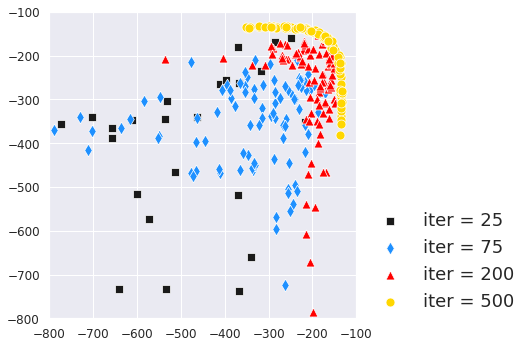

In [111]:
plt.figure(figsize=(7.5, 5))
plt.tick_params(labelsize=12)
plt.xlim(- 800, - 100)
plt.ylim(- 800, - 100)

keys = [25, 75, 200, 500]
ccc = ['k', 'dodgerblue', 'red', 'gold']
mmm = ['s', 'd', '^', 'o']

sns.set_theme()

for i, it in enumerate(keys):
    pts = out[it]
    scores = - morl_custom.deviation_from_pf(morl_custom.R_normalize(pts, mode='median'))
    pts = pts[scores > np.quantile(scores, q=0.5)]
    sns.scatterplot(data=pd.DataFrame(pts), x=0, y=1, color=ccc[i], s=80, edgecolors=ccc[i], 
                    marker=mmm[i], label='iter = {}'.format(it))
    
plt.xlabel(None)
plt.ylabel(None)
plt.legend(bbox_to_anchor=(1, 0.4), fontsize=18)
plt.tight_layout()
plt.savefig('evolve_pf.png', dpi=500)